In [315]:
for i in tqdm(range(len(x_train))):
    fp = '/home/rob/HWR/datasets/mnist/train/%s.png'%i
    img = 255 - x_train[i]
    cv2.imwrite(fp,img)

img.min(),img.max()
plt.imread(fp).min()
#fp = '/home/rob/HWR/datasets/IAMHist/washingtondb-v1.0/washingtondb-v1.0/data/word_images_normalized/272-17-04.png'

#img.min()
#img.min()

100%|██████████| 60000/60000 [00:06<00:00, 8948.38it/s]


0.0

In [1]:
def preprocess(img, imgSize, dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]])

    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img

    # transpose for TF
    img = cv2.transpose(target)

    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img

In [330]:
a = ['a']
a.remove('a')
a

[]

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import random
import numpy as np
import cv2
from SamplePreprocessor import preprocess


import re
from glob import glob




class Sample:
    "sample from the dataset"
    def __init__(self, gtText, filePath):
        self.gtText = gtText
        self.filePath = filePath


class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs, fps):
        self.imgs = np.stack(imgs, axis=0)
        self.gtTexts = gtTexts
        self.fps = fps
        

class DataLoader:
    "loads data which corresponds to IAM format, see: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database" 

    def __init__(self, dataPath, batchSize, imgSize, maxTextLen, included_datasets = ['iam','rimes','mnist','cvl','washington']):
        "loader for dataset at given location, preprocess images and text according to parameters"
        
        self.dataPath = dataPath
        self.maxTextLen = maxTextLen
        self.dataAugmentation = False
        self.currIdx = 0
        self.batchSize = batchSize
        self.imgSize = imgSize
        self.samples = []
        self.trainSamples = []
        self.validationSamples = []
        self.trainValSplit = 0.9

        self.add_datasets(included_datasets)
        for sample in self.trainSamples:
            if (len(sample.gtText) == 0) | (not os.path.exists(sample.filePath)):
                self.trainSamples.remove(sample)
        for sample in self.validationSamples:
            if (len(sample.gtText) == 0) | (not os.path.exists(sample.filePath)):
                self.validationSamples.remove(sample)
        
        # put words into lists
        self.trainWords = [x.gtText for x in self.trainSamples]
        self.validationWords = [x.gtText for x in self.validationSamples]

        # number of randomly chosen samples per epoch for training 
        self.numTrainSamplesPerEpoch = 150000 

        # start with train set
        self.trainSet()

        self.chars = set()
        for word in self.trainWords:
            self.chars = self.chars.union(set(list(word)))
        
        # list of all chars in dataset
        self.charList = sorted(list(self.chars))

    def add_datasets(self, included_datasets):
        for dataset in included_datasets:
            if dataset.lower() == 'iam':
                self.add_iam_dataset()
            elif dataset.lower() == 'rimes':
                self.add_rimes_dataset()
            elif dataset.lower() == 'mnist':
                self.add_mnist_dataset()
            elif dataset.lower() == 'cvl':
                self.add_cvl_dataset()
            elif dataset.lower() == 'washington':
                self.add_washington_dataset()
            else:
                self.warn('dataset %s not understood'%dataset)
        np.random.seed(42)
        self.trainSamples = list(np.random.permutation(self.trainSamples))
        self.validationSamples = list(np.random.permutation(self.validationSamples))
        
    def add_iam_dataset(self):
        f = open(os.path.join(self.dataPath,'IAM','words.txt'))
        samples = []
        for line in f:
            # ignore comment line
            if not line or line[0]=='#':
                continue


            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 9

            # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
            fileNameSplit = lineSplit[0].split('-')
            filePath = os.path.join(self.dataPath,'IAM','words',fileNameSplit[0],fileNameSplit[0] + '-' + fileNameSplit[1], lineSplit[0] + '.png')
            
            # GT text are columns starting at 9
            gtText = self.truncateLabel(' '.join(lineSplit[8:]), self.maxTextLen)
            
            if os.path.exists(filePath):
                samples += [Sample(gtText, filePath)]
        np.random.seed(42)
        np.random.permutation(samples)
        self.trainSamples += samples[:int(self.trainValSplit*len(samples))]
        self.validationSamples += samples[int(self.trainValSplit*len(samples)):]        
    
    def add_rimes_dataset(self):
        with open(os.path.join(self.dataPath,'RIMES','train','gt.txt'),'r') as f:
            for line in f:
                if not line:
                    continue
                
                lineSplit = line.strip().split(' ')
                fp = lineSplit[0]
                gtText = self.truncateLabel(' '.join(lineSplit[1:]), self.maxTextLen)
                fp = os.path.join(self.dataPath,'RIMES','train','imgs',fp)
                if os.path.exists(fp):
                    self.trainSamples += [Sample(gtText, fp)]
        
        with open(os.path.join(self.dataPath,'RIMES','val','gt.txt'),'r') as f:
            for line in f:
                if not line:
                    continue
                
                lineSplit = line.strip().split(' ')
                fp = lineSplit[0]
                gtText = self.truncateLabel(' '.join(lineSplit[1:]), self.maxTextLen)
                fp = os.path.join(self.dataPath,'RIMES','val','imgs',fp)
                if os.path.exists(fp):
                    self.validationSamples += [Sample(gtText, fp)]
        
    def add_mnist_dataset(self):
        y_train = np.loadtxt(os.path.join(self.dataPath,'mnist','train','y.txt')).astype('int')[1]
        for i in range(len(y_train)):
            fp = os.path.join(self.dataPath,'mnist','train','%s.png'%i)
            y = str(y_train[i])
            if os.path.exists(fp):
                self.trainSamples += [Sample(y, fp)]
        
        y_test = np.loadtxt(os.path.join(self.dataPath,'mnist','test','y.txt')).astype('int')[1]
        for i in range(len(y_test)):
            fp = os.path.join(self.dataPath,'mnist','test','%s.png'%i)
            y = str(y_train[i])
            if os.path.exists(fp):
                self.validationSamples += [Sample(y, fp)]
    
    def add_cvl_dataset(self):
        train_fps = glob(os.path.join(self.dataPath,'cvl/train/words/*/*.tif'))
        for fp in train_fps:
            gtText = '-'.join(fp.split('-')[4:]).split('.tif')[0]
            gtText = self.truncateLabel(gtText, self.maxTextLen)
            self.trainSamples += [Sample(gtText, fp)]
            
        test_fps = glob(os.path.join(self.dataPath,'cvl/test/words/*/*.tif'))
        for fp in test_fps:
            gtText = '-'.join(fp.split('-')[4:]).split('.tif')[0]
            gtText = self.truncateLabel(gtText, self.maxTextLen)
            self.validationSamples += [Sample(gtText, fp)]
    
    def add_washington_dataset(self):
        samples = []
        with open(os.path.join(self.dataPath,'IAMHist','washingtondb-v1.0','washingtondb-v1.0','ground_truth','word_labels.txt'), 'r') as f:
            for line in f.readlines():
                lineSplit = line.strip().split(' ')
                _id = lineSplit[0]
                _chars = lineSplit[1].split('-')
                word = ''
                for _char in _chars:
                    if re.match('^[a-z,A-Z]$',_char):
                        word += _char
                    elif re.match('^s_[0-9]$',_char):
                        word += _char[2]
                    elif re.match('^s_[0-9](?:th|st|rd|nd)$',_char):
                        word += _char[2:]
                    elif _char == 's_pt':
                        word += '.'
                    elif _char == 's_cm':
                        word += ','
                    elif _char == 's_mi':
                        word += '-'
                    elif _char == 's_sq':
                        word += ';'
                    elif _char == 's_qt':
                        word += "'"
                    elif _char == 's_s':
                        word += "s"
                    elif _char == 's_qo':
                        word += ':'
                    elif _char == 's_bl':
                        word += '('
                    elif _char == 's_br':
                        word += ')'
                    elif (_char == 's_et') | (_char == 's_GW') | (_char == 's_lb') | (_char == 's_sl'):
                        word = ''
                        continue
                if word != '':
                    word = self.truncateLabel(word, self.maxTextLen)
                    fp = os.path.join(self.dataPath,'IAMHist','washingtondb-v1.0','washingtondb-v1.0','data','word_images_normalized',_id+'.png')
                    if os.path.exists(fp):
                        samples += [Sample(word, fp)]
        np.random.seed(42)
        np.random.permutation(samples)
        self.trainSamples += samples[:int(self.trainValSplit*len(samples))]
        self.validationSamples += samples[int(self.trainValSplit*len(samples)):]
        

    def warn(self,msg):
        print('WARNING: %s'%msg)
        
    def truncateLabel(self, text, maxTextLen):
        # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
        # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        # If a too-long label is provided, ctc_loss returns an infinite gradient
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i-1]:
                cost += 2
            else:
                cost += 1
            if cost > maxTextLen:
                return text[:i]
        return text


    def trainSet(self):
        "switch to randomly chosen subset of training set"
        self.dataAugmentation = True
        self.currIdx = 0
        random.shuffle(self.trainSamples)
        self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]


    def validationSet(self):
        "switch to validation set"
        self.dataAugmentation = False
        self.currIdx = 0
        self.samples = self.validationSamples
        
    def predict(self, fps):
        "switch to validation set"
        self.dataAugmentation = False
        self.currIdx = 0
        predictionSamples = []
        for fp in fps:
            predictionSamples += [Sample([' ',fp])]
        self.samples = predictionSamples


    def getIteratorInfo(self):
        "current batch index and overall number of batches"
        return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)


    def hasNext(self):
        "iterator"
        return self.currIdx + self.batchSize <= len(self.samples)


    def getNext(self):
        "iterator"
        batchRange = range(self.currIdx, self.currIdx + self.batchSize)
        gtTexts = [self.samples[i].gtText for i in batchRange]
        fps = [self.samples[i].filePath for i in batchRange]
        imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
        self.currIdx += self.batchSize
        return Batch(gtTexts, imgs, fps)

In [2]:
dataPath = '/home/rob/HWR/datasets' 
batchSize = 10
imgSize = (128, 32)
maxTextLen = 32
included_datasets = ['iam','cvl','washington','mnist','rimes']
dataloader = DataLoader(dataPath, batchSize, imgSize, maxTextLen, included_datasets)

wtf


In [4]:
len(dataloader.samples),len(dataloader.trainSamples),len(dataloader.validationSamples)

(25000, 307675, 41631)

wtf
wtf
wtf


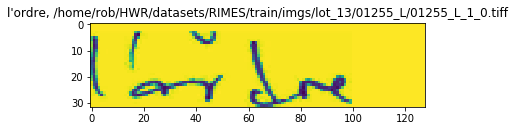

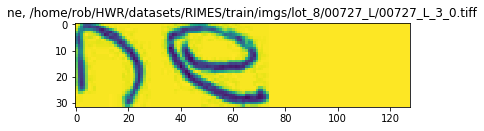

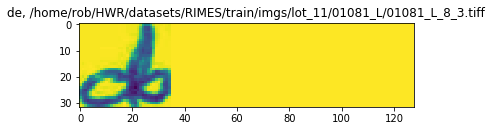

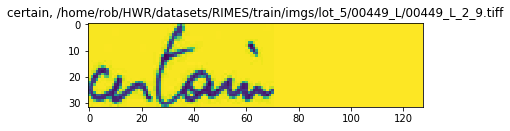

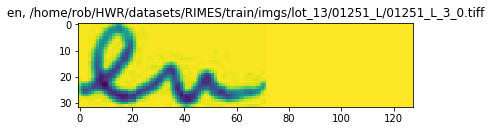

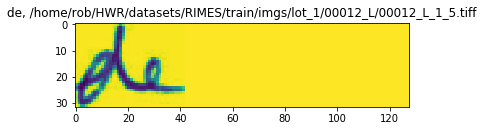

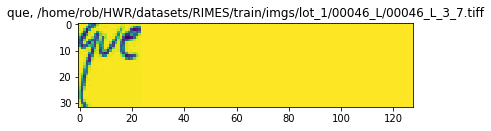

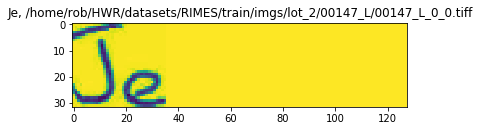

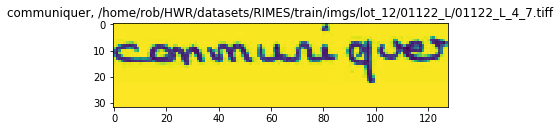

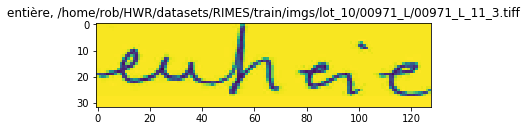

In [324]:
a = dataloader.getNext()
for i in range(len(a.imgs)):
    img = a.imgs[i]
    fp = a.fps[i]
    gtText = a.gtTexts[i]
    
    plt.figure()
    plt.imshow(img.T)
    plt.title(str(gtText) + ', ' + str(fp))

In [260]:
img.min(),img.max()

(-7.009660975027025, 0.26507681016603113)

In [212]:
os.path.exists('/home/rob/HWR/datasets/IAM/words/g06/g06-031m/g06-031m-06-03.png')

True

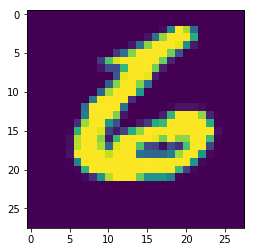

In [32]:
import numpy as np
import matplotlib.pyplot as plt
np.savetxt('/home/rob/HWR/datasets/mnist/test/y.txt',np.array([range(len(y_test)),y_test]))
for i in range(len(x_test)):
    img = x_test[i]
    plt.imsave('/home/rob/HWR/datasets/mnist/test/%s.png'%i,img)
plt.imshow(img)

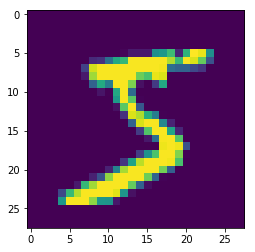

In [31]:
import numpy as np
import matplotlib.pyplot as plt
np.savetxt('/home/rob/HWR/datasets/mnist/train/y.txt',np.array([range(len(y_train)),y_train]))
for i in range(len(x_train)):
    img = x_train[i]
    plt.imsave('/home/rob/HWR/datasets/mnist/train/%s.png'%i,img)
plt.imshow(img)

In [30]:
np.loadtxt('/home/rob/HWR/datasets/mnist/train/y.txt').astype('int')

array([[    5,     0,     4, ...,     5,     6,     8],
       [    0,     1,     2, ..., 59997, 59998, 59999]])